In [1]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from ridge_utils.ridge import bootstrap_ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# === Setup paths ===
embedding_dir = "../results/embeddings/bert_XY"
story_files = sorted([f[:-6] for f in os.listdir(embedding_dir) if f.endswith("_X.npy")])
train_stories, test_stories = train_test_split(story_files, test_size=0.2, random_state=42)

voxel_limit = 20000 
alphas = np.logspace(0, 3, 20)

# === Standardization parameters (compute on training set only) ===
x_sum, x_sqsum, y_sum, y_sqsum, n_total = 0, 0, 0, 0, 0

for sid in train_stories:
    X = np.load(os.path.join(embedding_dir, f"{sid}_X.npy"))
    Y = np.load(os.path.join(embedding_dir, f"{sid}_Y.npy"))
    if voxel_limit:
        Y = Y[:, :voxel_limit]
    n = X.shape[0]
    x_sum += X.sum(0)
    x_sqsum += (X**2).sum(0)
    y_sum += Y.sum(0)
    y_sqsum += (Y**2).sum(0)
    n_total += n

x_mean = x_sum / n_total
x_std = np.sqrt(x_sqsum / n_total - x_mean**2 + 1e-8)
y_mean = y_sum / n_total
y_std = np.sqrt(y_sqsum / n_total - y_mean**2 + 1e-8)

In [3]:
# === Helper: load and z-score one story ===
def load_zscore_XY(story, voxel_limit=None):
    X = np.load(os.path.join(embedding_dir, f"{story}_X.npy"))
    Y = np.load(os.path.join(embedding_dir, f"{story}_Y.npy"))
    if voxel_limit:
        Y = Y[:, :voxel_limit]
    n = min(X.shape[0], Y.shape[0])
    X = (X[:n] - x_mean) / x_std
    Y = (Y[:n] - y_mean) / y_std
    return X, Y

# === Combine training and test sets ===
X_train_all, Y_train_all = [], []
for sid in train_stories:
    try:
        X, Y = load_zscore_XY(sid, voxel_limit)
        X_train_all.append(X)
        Y_train_all.append(Y)
    except Exception as e:
        print(f"⚠️ Skipping {sid}: {e}")
X_train_z = np.concatenate(X_train_all)
Y_train_z = np.concatenate(Y_train_all)
del X_train_all, Y_train_all 


In [4]:
# === Load test set
X_test_all, Y_test_all = [], []
for sid in test_stories:
    try:
        X, Y = load_zscore_XY(sid, voxel_limit)
        X_test_all.append(X)
        Y_test_all.append(Y)
    except Exception as e:
        print(f"⚠️ Skipping {sid}: {e}")
X_test_z = np.concatenate(X_test_all)
Y_test_z = np.concatenate(Y_test_all)
del X_test_all, Y_test_all

# === Run ridge regression
print(f"Training shape: X={X_train_z.shape}, Y={Y_train_z.shape}")
print(f"Test shape:     X={X_test_z.shape}, Y={Y_test_z.shape}")

wt, corrs, valalphas, _, _ = bootstrap_ridge(
    Rstim=X_train_z,
    Rresp=Y_train_z,
    Pstim=X_test_z,
    Presp=Y_test_z,
    alphas=alphas,
    nboots=20,
    chunklen=10,
    nchunks=3,
    normalpha=True
)


Training shape: X=(27266, 3072), Y=(27266, 20000)
Test shape:     X=(6712, 3072), Y=(6712, 20000)


/opt/packages/anaconda3-2024.10-1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


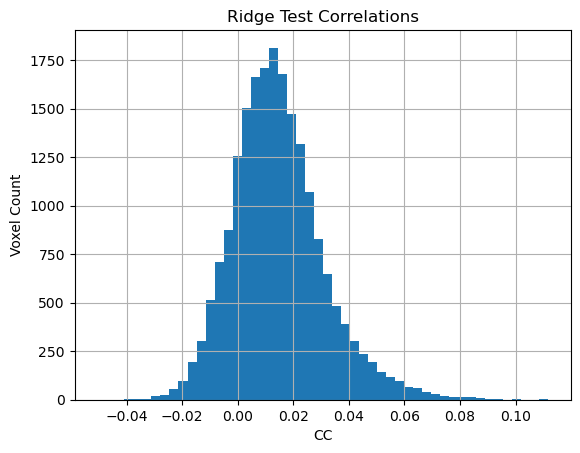

Mean CC: 0.014535726536052741
Median CC: 0.01300251789202446
Top 1% CC: 0.063770931266898
Top 5% CC: 0.04441733003105896


In [5]:
np.save("ridge_weights.npy", wt)
np.save("ridge_corrs.npy", corrs)

# === Plot
plt.hist(corrs, bins=50)
plt.title("Ridge Test Correlations")
plt.xlabel("CC")
plt.ylabel("Voxel Count")
plt.grid(True)
plt.show()

print("Mean CC:", np.mean(corrs))
print("Median CC:", np.median(corrs))
print("Top 1% CC:", np.percentile(corrs, 99))
print("Top 5% CC:", np.percentile(corrs, 95))

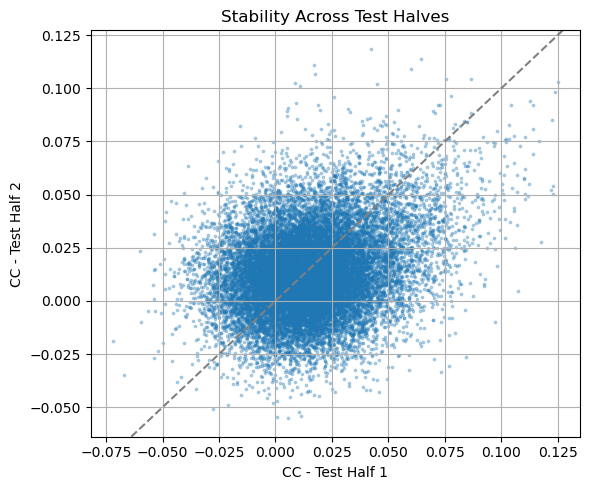

Stability (correlation of voxel CCs across halves): 0.26343088650240654


In [6]:
# Stability plot across test halves
def voxel_cc(y_true, y_pred):
    return np.array([
        np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
        for i in range(y_true.shape[1])
    ])

# Split test set in half by time
n = X_test_z.shape[0]
half = n // 2
Y_pred_1 = X_test_z[:half] @ wt
Y_pred_2 = X_test_z[half:] @ wt
Y_true_1 = Y_test_z[:half, :wt.shape[1]]
Y_true_2 = Y_test_z[half:, :wt.shape[1]]

# Compute voxel-wise correlations for both halves
cc_1 = voxel_cc(Y_true_1, Y_pred_1)
cc_2 = voxel_cc(Y_true_2, Y_pred_2)

# Clean NaNs
cc_1 = np.nan_to_num(cc_1)
cc_2 = np.nan_to_num(cc_2)

# Plot stability
plt.figure(figsize=(6, 5))
plt.scatter(cc_1, cc_2, alpha=0.3, s=3)
plt.xlabel("CC - Test Half 1")
plt.ylabel("CC - Test Half 2")
plt.title("Stability Across Test Halves")
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.grid(True)
plt.tight_layout()
plt.show()

# Report stability score
stability_score = np.corrcoef(cc_1, cc_2)[0, 1]
print("Stability (correlation of voxel CCs across halves):", stability_score)
